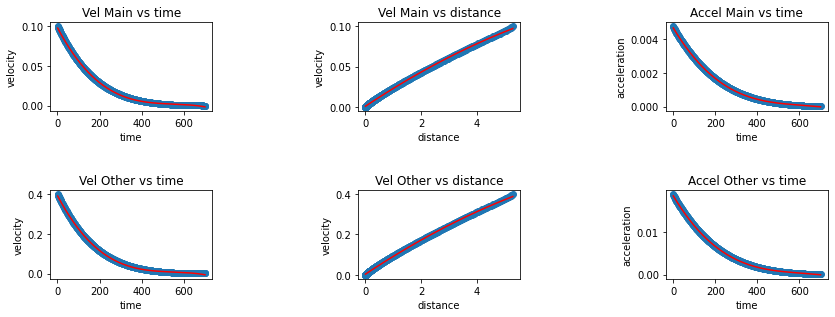

In [7]:
from gym_duckietown.simulator import Simulator
import matplotlib.pyplot as plt
import numpy as np
import math
import duckietown_world

env = Simulator(
        seed=123, # random seed
        map_name="straigh_road_obj",
        max_steps=500001, # we don't want the gym to reset itself
        domain_rand=0,
        camera_width=640,
        camera_height=480,
        accept_start_angle_deg=1,#at close to straight
        full_transparency=True,
        distortion=True,
    )  

time = []
angle = []

vel_other = []
vel_main = []

accel_lst_main = []
accel_lst_other = []

dist = []

#initializing the graphs
figure, axis = plt.subplots(2, 3)
plt.subplots_adjust(left=0.1, bottom=0.01, right=1.9, top=0.9, wspace=0.9, hspace=0.9)

#initial parameters for the car
dt = 0
TIME_STEP = 1
obj_dist = 0

speed = 0.1
speed_other = 0.4
accel = 0
accel_other = 0


for obj in env.objects:
    obj.velocity = speed_other

while dt < 700:
    lane_pose = env.get_lane_pos2(env.cur_pos, env.cur_angle)
    distance_to_road_center = lane_pose.dist
    angle_from_straight_in_rads = lane_pose.angle_rad
    k_p = 10
    k_d = 1
    steering = k_p*distance_to_road_center + k_d*angle_from_straight_in_rads 
    dt = dt + 1

    ###### Getting info to be printed on the graphs
    obs, reward, done, misc = env.step([speed, steering])
    
    info = misc["Simulator"]
    pos = info["cur_pos"]
    time.append(dt)
    
    obj_dist = pos[0] * -1
    for obj in env.objects:
        obj_dist += obj.pos[0]
                
    main_dist = speed * obj_dist /(speed + speed_other)
    other_dist = speed_other * obj_dist /(speed + speed_other)
    
    accel = math.pow(speed, 2) /(2.0 *main_dist)
    accel_other = math.pow(speed_other, 2) /(2.0 * other_dist)
    speed -= accel * 0.12 #0.032954733427833
    speed_other -= accel_other * 0.12 #0.0400290498945
      

    dist.append(obj_dist)
    accel_lst_main.append(accel)
    accel_lst_other.append(accel_other)
    vel_main.append(speed)
    vel_other.append(speed_other)
    
    if(speed <= 0):
        speed = 0
    
    if(speed_other <= 0):
        speed_other = 0

    for obj in env.objects:
        obj.velocity = speed_other
    
    env.render()

    if done:
        if reward < 0:
            print('*** CRASHED ***')
        break

trend_1 = np.polyfit(time, vel_main, 3)
p1 = np.poly1d(trend_1)
axis[0][0].scatter(time, vel_main)
axis[0][0].set_title("Vel Main vs time")
axis[0][0].set_xlabel("time")
axis[0][0].set_ylabel("velocity")
axis[0][0].plot(time, p1(time), color="red")

trend_2 = np.polyfit(dist, vel_main, 2)
p2 = np.poly1d(trend_2)
axis[0][1].scatter(dist, vel_main)
axis[0][1].set_title("Vel Main vs distance")
axis[0][1].set_xlabel("distance")
axis[0][1].set_ylabel("velocity")
axis[0][1].plot(dist, p2(dist), color="red")

trend_3 = np.polyfit(time, accel_lst_main, 3)
p3 = np.poly1d(trend_3)
axis[0][2].scatter(time, accel_lst_main)
axis[0][2].set_title("Accel Main vs time")
axis[0][2].set_xlabel("time")
axis[0][2].set_ylabel("acceleration")
axis[0][2].plot(time, p3(time), color="red")

trend_4 = np.polyfit(time, vel_other, 3)
p4 = np.poly1d(trend_4)
axis[1][0].scatter(time, vel_other)
axis[1][0].set_title("Vel Other vs time")
axis[1][0].set_xlabel("time")
axis[1][0].set_ylabel("velocity")
axis[1][0].plot(time, p4(time), color="red")

trend_5 = np.polyfit(dist, vel_other, 2)
p5 = np.poly1d(trend_5)
axis[1][1].scatter(dist, vel_other)
axis[1][1].set_title("Vel Other vs distance")
axis[1][1].set_xlabel("distance")
axis[1][1].set_ylabel("velocity")
axis[1][1].plot(dist, p5(dist), color="red")

trend_6 = np.polyfit(time, accel_lst_other, 3)
p6 = np.poly1d(trend_6)
axis[1][2].scatter(time, accel_lst_other)
axis[1][2].set_title("Accel Other vs time")
axis[1][2].set_xlabel("time")
axis[1][2].set_ylabel("acceleration")
axis[1][2].plot(time, p6(time), color="red")

plt.savefig("Dynamic_Reactive_Graphs/Dist_16_Main_Vel_0.1_Other_Vel_0.4.png")

plt.show()